In [18]:
%matplotlib inline
# Import Libraries
import easygui
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt


In [19]:
datapath = easygui.fileopenbox()
data = np.genfromtxt(datapath,delimiter=",",skip_header=1)
#data = np.loadtxt(datapath,delimiter=",",skiprows=1)
filename = (datapath.rsplit('/',1)[-1]).rsplit('.',1)[0]
print(data.shape)
data = data[~np.isnan(data).any(axis=1)] # removes rows with nan values. this will get rid of extra commas at the end of files, as well as handle datasets of different lengths 

try:
    numcols = data.shape[1]
except:
    numcols = 1
with open(datapath, newline='') as f:
    reader = csv.reader(f)
    rawheaders = next(reader)
    headers = []
    for header in rawheaders:
        headers.append(header.rsplit('/',1)[-1])
print("Headers as imported from CSV: " + str(headers))
print("Name of files to be saved: " + filename)


(4329, 8)
Headers as imported from CSV: ['60ul_oldgasket_equalentry_OTtips #1_y', '60ul_oldgasket_equalentry_OTtips #2_y', '60ul_oldgasket_equalentry_OTtips #3_y', '60ul_oldgasket_inequalentry_OTtips #1_y', '60ul_oldgasket_inequalentry_OTtips #2_y', '60ul_oval_inequalentry_OTtips #1_y', '60ul_oval_inequalentry_OTtips #2_y', '60ul_oval_inequalentry_OTtips #3_y']
Name of files to be saved: newprog


In [20]:
# colors = []
# for i in range(numcols):
#     colors.append((i*255/numcols)/255)
# colors

In [21]:
class Dataset:
    def __init__(self, data):
        self.data = data        
        # Find the flipping points
        self.flips = [] # list of flips in a dataset
        above = True
        threshold = np.mean(data)
        #print(threshold)
        for i in range(data.shape[0]):
            # previous datapoint was above and this datapoint is below threshold
            # OR previous datapoint was NOT above and this datapoint is NOT below threshold
            if above == (data[i] < threshold):
                self.flips.append(i)
                above = not above
        
        self.times = np.split(np.arange(len(data)), self.flips)
        self.segments = np.split(self.data, self.flips)
        self.means = [np.mean(x) for x in self.segments]
        self.time_means = [np.mean(x) for x in self.times]
        self.high_means = self.means[2::2]
        self.low_means = self.means[1::2]
        self.high_time_means = self.time_means[2::2]
        self.low_time_means = self.time_means[1::2]
        self.stdevs = [np.std(x) for x in self.segments]
        self.high_stdevs = self.stdevs[2::2]
        self.low_stdevs = self.stdevs[1::2]
        self.total_high_mean = np.mean(self.means[2::2])
        self.total_low_mean = np.mean(self.means[1::2])
        self.total_high_stdev = np.std(self.stdevs[2::2])
        self.total_low_stdev = np.std(self.stdevs[1::2])
        
#         print("Length of self.low_stdevs: " + str(len(self.low_stdevs)))
#         print("Length of self.high_stdevs: " + str(len(self.high_stdevs)))
        self.highlow_stdevs = np.empty(((int(len(self.high_stdevs) + len(self.low_stdevs))),), dtype = self.total_high_stdev.dtype)
#         print("Length of self.highlow_stdevs: " + str(self.highlow_stdevs.size))
        self.highlow_stdevs[1::2] = np.array(self.high_stdevs)
        self.highlow_stdevs[0::2] = np.array(self.low_stdevs)
#         print("Length of self.means before pop: " + str(len(self.means)))
        self.means.pop(0) # Pop first datapoint, since it is before any fluid has entered the flow cell
#         print("Length of self.means after pop: " + str(len(self.means)))
        
        self.contrast_means = np.divide(np.array(self.high_means),np.array(self.low_means[:-1]))

        # plot datapoints as line plot
    def plot_dataset(self, color = "C0"):
        plt.plot(self.data, linewidth = 1)#, color = color)
        # plot points of means of high and low segments, with errorbars from stdevs from mean of high or low
#     def plot_means(self, color = "C0"):
#         plt.errorbar(self.high_time_means, self.high_means, self.high_stdevs, fmt = 'none', color = color)
#         plt.scatter(self.high_time_means, self.high_means, s = 5, color = color)
#         plt.errorbar(self.low_time_means, self.low_means, self.low_stdevs, fmt = 'none', color = color)
#         plt.scatter(self.low_time_means, self.low_means, s = 5, color = color)
#         # plot points of means of high and low segments, with errorbars from stdevs from mean of highs or lows. Different datasets are offset to aid readability. 
#     def plot_means2(self, color = "C0", offset=0):
#         t = np.arange(len(self.high_means)) + offset
#         plt.errorbar(t, self.high_means, self.high_stdevs, fmt = 'none', color = color)
#         plt.scatter(t, self.high_means, s = 7, color = color)
#         t = np.arange(len(self.low_means)) + offset
#         plt.errorbar(t, self.low_means, self.low_stdevs, fmt = 'none', color = color)
#         plt.scatter(t, self.low_means, s = 7, color = color)
    def plot_means3(self, offset=0):
        t = np.arange(len(self.means)) + offset
        # print(self.highlow_stdevs)
        plt.errorbar(t, self.means, self.highlow_stdevs, fmt = 'none')
        plt.scatter(t, self.means, s = 7)
        # plot contrast of means
    def plot_contrast_means(self, color = "C0"):
        plt.plot(self.high_time_means, self.contrast_means)


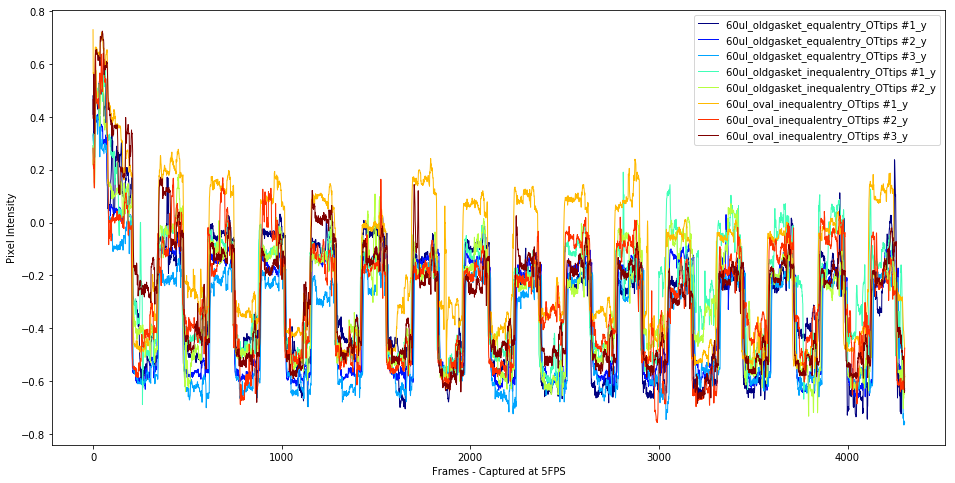

In [22]:
plt.figure(figsize=(16, 8))
plt.tight_layout()
colormap = plt.cm.jet
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, numcols))))
for i in range(numcols):
    d_sets = Dataset(data[:,i])
    d_sets.plot_dataset(color = "C" + str(i))
plt.legend(headers)
plt.xlabel("Frames - Captured at 5FPS")
plt.ylabel("Pixel Intensity")
plt.savefig(filename + "_raw" + '.pdf')

In [23]:
# plt.figure(figsize=(16, 8))
# plt.tight_layout()
# for i in range(numcols):
#     d = Dataset(data[:,i])
#     d.plot_means2(color = "C" + str(i), offset=i*0.08)
# plt.legend(labels = headers)
# plt.xlabel("Segment Occurences")
# plt.ylabel("Pixel Intensity")
# plt.savefig(filename + "_means" + '.pdf')

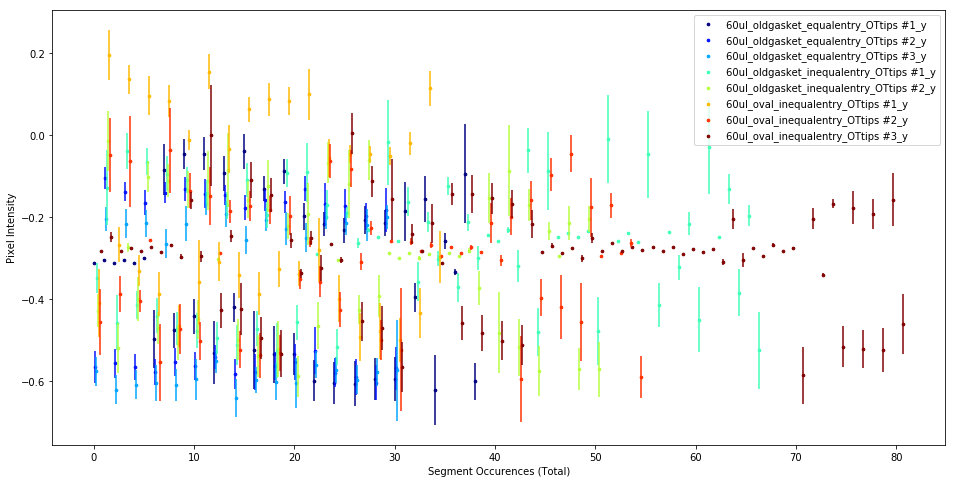

In [24]:
plt.figure(figsize=(16, 8))
plt.tight_layout()
colormap = plt.cm.jet
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, numcols))))
for i in range(numcols):
    d = Dataset(data[:,i])
    d.plot_means3(offset=i*0.1)
plt.legend(labels = headers)
plt.xlabel("Segment Occurences (Total)")
plt.ylabel("Pixel Intensity")
plt.savefig(filename + "_means" + '.pdf')

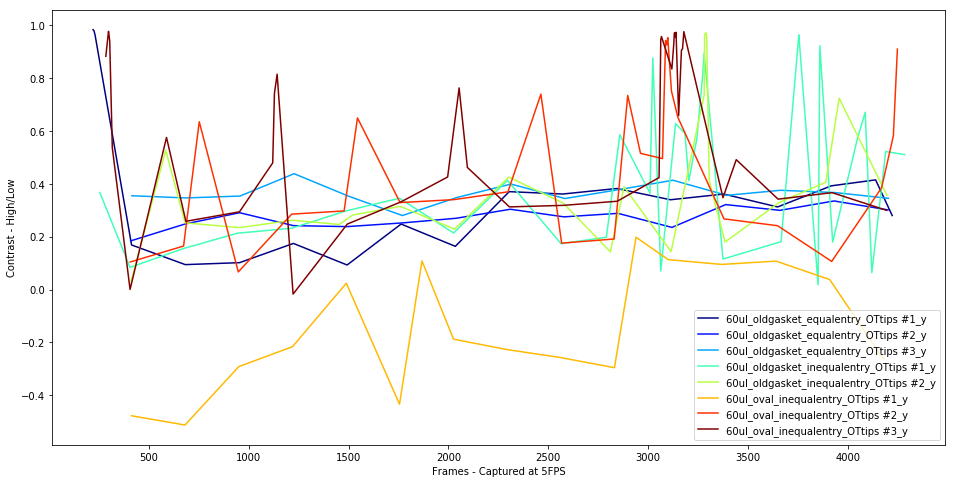

In [25]:
plt.figure(figsize=(16, 8))
plt.tight_layout()
labels = []
colormap = plt.cm.jet
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, numcols))))
for i in range(numcols):
    d_con = Dataset(data[:,i])
    d_con.plot_contrast_means()
    labels.append("Run " + str(i))
plt.legend(labels)
plt.xlabel("Frames - Captured at 5FPS")
plt.ylabel("Contrast - High/Low")
plt.legend(labels = headers)
plt.savefig(filename + "_contrast" + '.pdf')